In [1]:
from qiskit import QuantumRegister, QuantumCircuit, transpile, assemble, Aer, IBMQ
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
pi = np.pi

In [2]:
## Initial settings

nqubits = 4 # total number of qubits

na = 1 # number of qubits representing the ancilla
ne = 2 # number of qubits representing the eigenvalues
nb = 1 # number of qubits representing the solution b

# Initialize the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qra = qr[0:na] #ancilla register
qre = qr[na:na+ne] # clock register
qrb = qr[na+ne:na+ne+nb] # solution b register

qc.x(qrb) # flip b register from 0 to 1
# |b> prepared
# initial value for |x1x2x3x4> is ∣0001>

In [3]:
## Phase estimation

# create superposition
qc.h(qre[0])
qc.h(qre[1])
    
# apply C-U gates
# let t0=2pi

qc.cu(pi/2,-pi/2,pi/2,3*pi/4,qre[0],qrb[0])
qc.cu(pi,pi,0,0,qre[1],qrb[0])


# qc.x(qre[0])
# inverse quantum fourier transform
# qc.swap(qre[0],qre[1])

qc.h(qre[1])
qc.cp(-np.pi/2,qre[0],qre[1]) # controlled S dagger gate, ie controlled R2 dagger gate
qc.h(qre[0])

In [4]:
## Controlled rotation
# qc.swap(qre[0],qre[1])

# apply Ry
qc.cu(pi,0,0,0,qre[1],qra)
qc.cu(pi/3,0,0,0,qre[0],qra)

In [5]:
## Uncompute
# qc.swap(qre[0],qre[1])
# qc.x(qre[0])
qc.h(qre[0])
qc.cp(np.pi/2,qre[0],qre[1])
qc.h(qre[1])
# qc.swap(qre[0],qre[1])


qc.cu(pi,pi,0,0,qre[1],qrb[0])
qc.cu(pi/2,pi/2,-pi/2,-3*pi/4,qre[0],qrb[0])


qc.h(qre[1])
qc.h(qre[0])

In [6]:
## Measurement
# qc.measure_all()
qc.measure_all()

In [7]:
qc.draw()

»
  q0_0: ───────────────────────────────────────────────────────────────»
        ┌───┐                                                     ┌───┐»
  q0_1: ┤ H ├───────────■────────────────────────────────■────────┤ H ├»
        ├───┤           │                          ┌───┐ │P(-π/2) └───┘»
  q0_2: ┤ H ├───────────┼──────────────────■───────┤ H ├─■─────────────»
        ├───┤┌──────────┴───────────┐┌─────┴──────┐└───┘               »
  q0_3: ┤ X ├┤ U(π/2,-π/2,π/2,3π/4) ├┤ U(π,π,0,0) ├────────────────────»
        └───┘└──────────────────────┘└────────────┘                    »
meas: 4/═══════════════════════════════════════════════════════════════»
                                                                       »
«        ┌────────────┐┌──────────────┐                                 »
«  q0_0: ┤ U(π,0,0,0) ├┤ U(π/3,0,0,0) ├─────────────────────────────────»
«        └─────┬──────┘└──────┬───────┘┌───┐                            »
«  q0_1: ──────┼──────────────■────────┤ H ├─■──────────────────────────»
«              │                       └───┘ │P(π/2) ┌───┐              »
«  q0_2: ──────■─────────────────────────────■───────┤ H ├──────■───────»
«                                                    └───┘┌─────┴──────┐»
«  q0_3: ─────────────────────────────────────────────────┤ U(π,π,0,0) ├»
«                                                         └────────────┘»
«meas: 4/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                                       ░ ┌─┐         
«  q0_0: ───────────────────────────────░─┤M├─────────
«                                 ┌───┐ ░ └╥┘┌─┐      
«  q0_1: ────────────■────────────┤ H ├─░──╫─┤M├──────
«                    │            ├───┤ ░  ║ └╥┘┌─┐   
«  q0_2: ────────────┼────────────┤ H ├─░──╫──╫─┤M├───
«        ┌───────────┴───────────┐└───┘ ░  ║  ║ └╥┘┌─┐
«  q0_3: ┤ U(π/2,π/2,-π/2,-3π/4) ├──────░──╫──╫──╫─┤M├
«        └───────────────────────┘      ░  ║  ║  ║ └╥┘
«meas: 4/══════════════════════════════════╩══╩══╩══╩═
«                                          0  1  2  3

In [8]:
simulator = Aer.get_backend('aer_simulator')
result = simulator.run(qc).result()

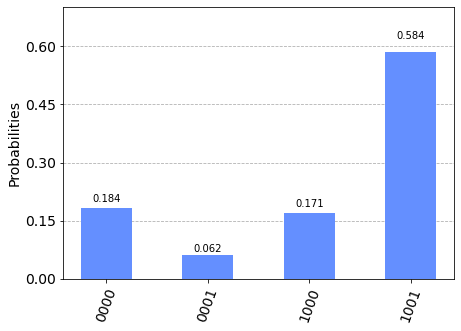

In [9]:
counts = result.get_counts(qc)
plot_histogram(counts)

In [10]:
counts

{'0001': 63, '1000': 175, '0000': 188, '1001': 598}

In [11]:

# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [12]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


In [13]:
job

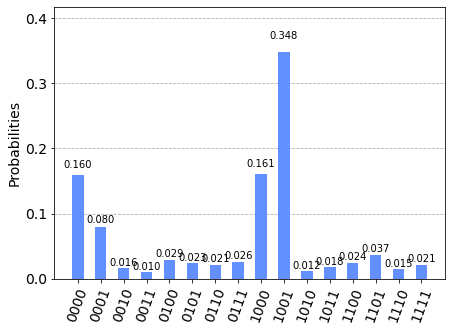

In [14]:
counts = job.result().get_counts()
plot_histogram(counts)

In [15]:
shots = 4096
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


In [16]:
job

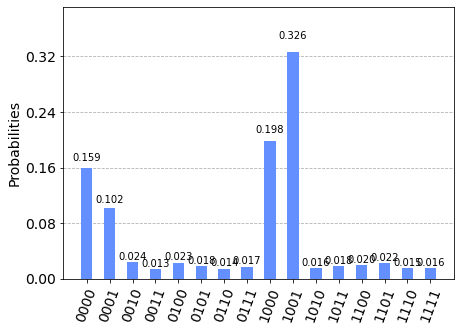

In [17]:
counts = job.result().get_counts()
plot_histogram(counts)

In [18]:
shots = 10240
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


In [19]:
job

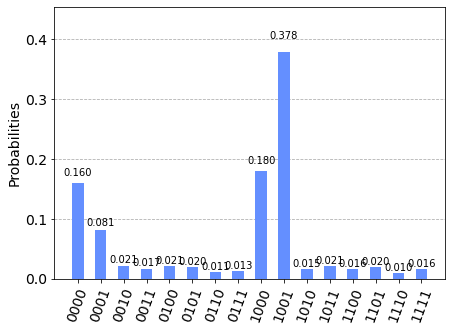

In [20]:
counts = job.result().get_counts()
plot_histogram(counts)

In [21]:
shots = 1024
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


In [22]:
job

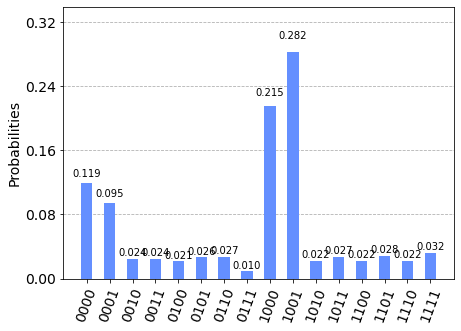

In [23]:
counts = job.result().get_counts()
plot_histogram(counts)